In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import string
from PIL import Image, ImageFont, ImageDraw, ImageOps
import copy
from decimal import *

Populating the interactive namespace from numpy and matplotlib


## Input

In [2]:
# a + b = c
a = 10
b = 100
c = 300
noise = 0.2

## Useful functions

In [3]:
def epsilon_close(a, b, epsilon):
    return (a < b + epsilon) and (a > b - epsilon)

def xor(a, b):
    return bool(a) != bool(b)

def get_bits_length(a):
    cur = a
    length = 0
    while cur != 0:
        cur = int(cur / 2)
        length += 1
    return length

def get_bits(a, size):
    bits = np.zeros(size, int)
    cur = a
    for i in range(size):
        bits[size - 1 - i] = cur % 2
        cur /= 2
    return bits

## Load images of 0 and 1

40 30


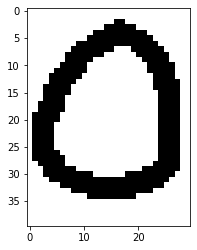

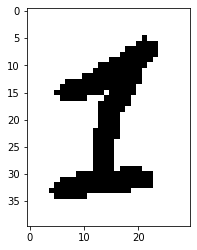

In [4]:
numbers = []

numbers.append(np.array(Image.open("./numbers/0.png")))
numbers.append(np.array(Image.open("./numbers/1.png")))

numbers = np.array(numbers)

height, width, _ = numbers[0].shape

print(height, width)

imshow(numbers[0], cmap='gray')
show()

imshow(numbers[1], cmap='gray')
show()

## Generate Image

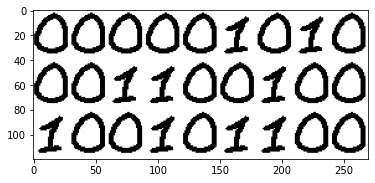

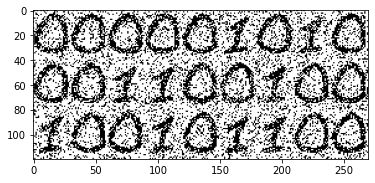

In [5]:
size = max(get_bits_length(a), get_bits_length(b), get_bits_length(c))

bits = []
bits.append(get_bits(a, size))
bits.append(get_bits(b, size))
bits.append(get_bits(c, size))
bits = np.array(bits)

image = np.zeros((height * 3, width * size))
for i in range(3):
    for y in range(height):
        for j in range(size):
            for x in range(width):
                image[i * height + y][j * width + x] = int(numbers[bits[i][j]][y][x][0] / 255)
                
imshow(image, cmap='gray')
show()

for y in range(height * 3):
    for x in range(width * size):
        rand = random.random()
        if rand < noise:
            image[y][x] = 1 - image[y][x]
            
imshow(image, cmap='gray')
show()

## Functions for solving the problem

In [6]:
def sum_penalty(img, ref):
    penalty = 0
    for y in range(height * 3):
        for x in range(width):
            penalty += int(img[y][x] != ref[y][x])
    return penalty
            
def prob_penalty(img, ref):
    penalty = 0.
    ln = np.log(noise)
    l1_n = np.log(1 - noise)
    for y in range(height * 3):
        for x in range(width):
            penalty += ln if (img[y][x] != ref[y][x]) else l1_n
    return penalty
            
def generate_column(n):
    img = np.zeros((3 * height, width))
    for i in range(3):
        for y in range(height):
            for x in range(width):
                img[i * height + y][x] = int(numbers[n[i]][y][x][0] / 255)
    return img

## Initializing some variable

In [7]:
fs = np.zeros((size, 2))
ucs = np.zeros((size, 2), int)
ks = np.zeros((size, 2), int)
f = np.zeros((2, 2, 8))

ucuc = [0, 3, 5]
ucuc_ = [1]
uc_uc = [6]
uc_uc_ = [2, 4, 7]

columns = np.zeros((8, 3 * height, width))

for i in range(8):
    bits = get_bits(i, 3)
    print(bits, i)
    columns[i] = generate_column(bits)

[0 0 0] 0
[0 0 1] 1
[0 1 0] 2
[0 1 1] 3
[1 0 0] 4
[1 0 1] 5
[1 1 0] 6
[1 1 1] 7


## Solving

In [8]:
# Calcultaing fs[0]
for uc1 in range(2):
    for uc2 in range(2):
        for i in range(8):
            f[uc1][uc2][i] = np.inf

for uc in ucuc:
    f[0][0][uc] = sum_penalty(image[:,-width:], columns[uc])  
for uc in uc_uc:
    f[1][0][uc] = sum_penalty(image[:,-width:], columns[uc])

for uc in range(2):
    fs[0][uc] = np.min(f[uc])
    amin = np.argmin(f[uc])
    ucs[0][uc] = int(amin / 8)
    ks[0][uc]= int(amin % 8)
    
for i in range(1, size):
    for uc in ucuc:
        f[0][0][uc] = sum_penalty(image[:,-width * (i + 1):-width * i], columns[uc]) + fs[i - 1][0]
    for uc in ucuc_:
        f[0][1][uc] = sum_penalty(image[:,-width * (i + 1):-width * i], columns[uc]) + fs[i - 1][1]
        
    for uc in uc_uc:
        f[1][0][uc] = sum_penalty(image[:,-width * (i + 1):-width * i], columns[uc]) + fs[i - 1][0]
    for uc in uc_uc_:
        f[1][1][uc] = sum_penalty(image[:,-width * (i + 1):-width * i], columns[uc]) + fs[i - 1][1]

    for uc in range(2):
        fs[i][uc] = np.min(f[uc])
        amin = np.argmin(f[uc])
        ucs[i][uc] = int(amin / 8)
        ks[i][uc]= int(amin % 8)
        
answer = [ks[size - 1][0]]
prev = 0
current = 0
for i in range(size - 2, -1, -1):
    answer.append(ks[i][ucs[i + 1][prev]])
    prev = ucs[i + 1][prev]
    current += 1 

Answer


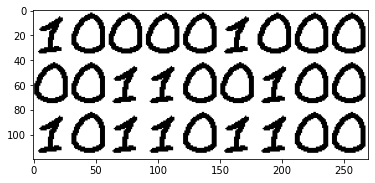

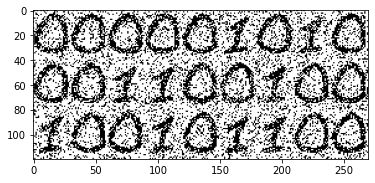

In [9]:
img_ans = np.zeros((3 * height, width * size))
for i in range(size):
    img_ans[:,width * i:width*(i + 1)] = generate_column(get_bits(answer[i], 3))

print("Answer")
imshow(img_ans, cmap='gray')
show()
img_ans *= 255
img_ans = img_ans.astype(np.uint8)
res_img = Image.fromarray(img_ans)
res_img.save("res_" + str(noise) + "_" + str(a) + "+" + str(b) + "=" + str(c) + ".png")

imshow(image, cmap='gray')
show()
image *= 255
image = image.astype(np.uint8)
ori_img = Image.fromarray(image)
ori_img.save("org_" +str(noise) + "_" +str(a) + "+" + str(b) + "=" + str(c) + ".png")